In this project, we combined email datasets from multiple sources for phishing detection. The combined dataset (before cleaning) includes :

Enron (Benign):
~15,000 non-phishing emails extracted from the Enron email corpus — widely regarded as a reliable dataset for legitimate communications.

Kaggle Phishing Dataset:
~7,500 phishing emails collected from Kaggle's phishing email dataset, labeled as phishing (label = 1).

UVic Phishing Dataset:
A small set of phishing emails manually labeled or collected from external academic sources.

## 1.Preprocessing Steps

Standardized column names and encodings.

Added a label column:

1 for phishing

0 for benign (Enron)

Concatenated all datasets with a Source column.

Checked and removed duplicate emails (based on the Message field), even if they came from different sources.

Saved final result as combined_raw_dataset.csv.


In [42]:
!pip install seaborn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [43]:
!pip install nltk


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [44]:
!pip install wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from wordcloud import WordCloud
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/azaleadj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/azaleadj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/azaleadj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/azaleadj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
import os

# 修改当前目录
os.chdir("/Users/azaleadj/Desktop/Uvic/summer/592/project/Summer-2025-ECE-597-Group4/Data Preprocessing")

# 验证是否修改成功
print("Current directory:", os.getcwd())


Current directory: /Users/azaleadj/Desktop/Uvic/summer/592/project/Summer-2025-ECE-597-Group4/Data Preprocessing


Preprocessing Steps
Standardized column names and encodings.

Added a label column:

1 for phishing

0 for benign (Enron)

Concatenated all datasets with a Source column.

Checked and removed duplicate emails (based on the Message field), even if they came from different sources.

Saved final result as combined_raw_dataset.csv.


In [47]:
df = pd.read_csv('CaptstoneProjectData_2025.csv')
df.head()
df.shape

(2576, 4)

In [48]:
print("Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
df.sample(3)

Shape: (2576, 4)

Column Names: ['Subject', 'Body', 'Unnamed: 2', 'Unnamed: 3']

Missing values:
 Subject        109
Body             5
Unnamed: 2    2576
Unnamed: 3    2576
dtype: int64

Data Types:
 Subject        object
Body           object
Unnamed: 2    float64
Unnamed: 3    float64
dtype: object


,Subject,Body,Unnamed: 2,Unnamed: 3
727,Release pending messages,Notice: This message was sent from outside the...,NaN,NaN
1334,ICT Help-desk,"Attention Email User,\r\n\r\n\r\n\r\nIT depart...",NaN,NaN
327,***SPAM Suspected*** Order Confirmation,\r\nMicrosoft Account\r\n\r\nInvoice Id : MS-2...,NaN,NaN


In [49]:
# load Enron dataset
enron_df = pd.read_csv("enron_emails.csv")

enron_df.head()
enron_df.shape

enron_sampled = enron_df.sample(n=150000, random_state=42)  # extract 150000 data from enron

print("data devisions after sampled：", enron_sampled.shape)
print(enron_sampled.head())


data devisions after sampled： (150000, 2)
                                              file  \
427616                     shackleton-s/sent/1912.   
108773                    farmer-d/logistics/1066.   
355471                  parks-j/deleted_items/202.   
457837  stokley-c/chris_stokley/iso/client_rep/41.   
124910               germany-c/all_documents/1174.   

                                                  message  
427616  Message-ID: <21013688.1075844564560.JavaMail.e...  
108773  Message-ID: <22688499.1075854130303.JavaMail.e...  
355471  Message-ID: <27817771.1075841359502.JavaMail.e...  
457837  Message-ID: <10695160.1075858510449.JavaMail.e...  
124910  Message-ID: <27819143.1075853689038.JavaMail.e...  


In [50]:
def extract_body(raw_msg):
    try:
        return raw_msg.split('\n\n', 1)[1]
    except IndexError:
        return ""

enron_sampled['body'] = enron_sampled['message'].apply(extract_body)
enron_sampled['label'] = '0'
enron_sampled_clean = enron_sampled[['body', 'label']].rename(columns={'body': 'Message'})
enron_sampled_clean.head()


,Message,label
427616,Bill: Thanks for the info. I also spoke wit...,0
108773,"Aimee,\nPlease check meter #1591 Lamay gas lif...",0
355471,GCCA Crawfish and rip-off raffle & over-priced...,0
457837,"<<Keoni.zip>> Chris, per your request here ar...",0
124910,I'm trying to change the Receipt Meter on deal...,0


In [51]:
# find phishing email dataset from kaggle

kaggle_phishing_df = pd.read_csv("kaggle_phishing_email.csv")
kaggle_phishing_df.shape

kaggle_phishing_df['label'].value_counts()

# kaggle_phishing_df[kaggle_phishing_df['label'] == 1].head(10)


kaggle_phishing_samples = kaggle_phishing_df[kaggle_phishing_df['label'] == 1].sample(n=7500, random_state=42)

kaggle_phishing_samples.head()

uvic_phishing = df 
uvic_phishing.head()

,Subject,Body,Unnamed: 2,Unnamed: 3
0,®Review your shipment details / Shipment Notif...,Notice: This message was sent from outside the...,NaN,NaN
1,Υоur ассоunt іѕ оn hоld,\r\nVotre réponse a bien été prise en compte.\...,NaN,NaN
2,Completed: Invoice # KZ89TYS2564 from-Bestbuy....,Notice: This message was sent from outside the...,NaN,NaN
3,UVic IMPORTANT NOTICE!,Your UVIC account has been filed under the lis...,NaN,NaN
4,You have (6) Suspended incoming messages,\r\n\r\nMessage generated from uvic.ca source...,NaN,NaN


In [52]:
uvic_phishing_df = uvic_phishing.rename(columns={"text_combined": "Message"}) if "text_combined" in uvic_phishing.columns else uvic_phishing
# creat column " Message"
# print(uvic_phishing_df.columns)
# uvic_phishing_df.head()

In [53]:

uvic_phishing_df['Message'] = uvic_phishing['Subject'].fillna('') + ' ' + uvic_phishing['Body'].fillna('')
uvic_phishing_df['label'] = 1  # phishing emals
uvic_phishing_df['Source'] = 'UVic' 

uvic_phishing_df = uvic_phishing_df[['Message', 'label','Source']]
uvic_phishing_df.head()


,Message,label,Source
0,®Review your shipment details / Shipment Notif...,1,UVic
1,Υоur ассоunt іѕ оn hоld \r\nVotre réponse a bi...,1,UVic
2,Completed: Invoice # KZ89TYS2564 from-Bestbuy....,1,UVic
3,UVic IMPORTANT NOTICE! Your UVIC account has b...,1,UVic
4,You have (6) Suspended incoming messages \r\n...,1,UVic


In [54]:

kaggle_phishing_samples = kaggle_phishing_samples.rename(columns={"text_combined": "Message"}) if "text_combined" in kaggle_phishing_samples.columns else kaggle_phishing_samples
kaggle_phishing_samples['Source'] = 'other'
enron_sampled_clean_df = enron_sampled_clean.rename(columns={"text_combined": "Message"}) if "text_combined" in enron_sampled_clean.columns else enron_sampled_clean
enron_sampled_clean_df['Source'] = 'enron'
kaggle_phishing_samples.head
enron_sampled_clean_df.head
uvic_phishing_df.shape
# enron_sampled_clean_df.shape

(2576, 3)

In [55]:
# combine three datasets
all_emails_df = pd.concat([
    kaggle_phishing_samples[['Message', 'label','Source']],
    uvic_phishing_df[['Message', 'label','Source']],
    enron_sampled_clean_df[['Message', 'label', 'Source']]
], ignore_index=True)


print(all_emails_df.shape)
print(all_emails_df['label'].value_counts())


(160076, 3)
label
0    150000
1     10076
Name: count, dtype: int64


In [56]:
before = all_emails_df.shape[0]
all_emails_df.drop_duplicates(subset='Message', inplace=True)
after = all_emails_df.shape[0]
print(f"deleted duplicated emails: {before - after} ")

deleted duplicated emails: 36094 


In [57]:
import re
def clean_text(text):
    text = text.lower()
    # keep URL、email、HTML,number,$,@,:/
    
    text = re.sub(r'[^\x00-\x7f]', ' ', text)              # delete non ASCII
    text = re.sub(r'\b[a-z]{1,2}\b', '', text)             # delet short word
    text = re.sub(r'[^a-z0-9\s@$:/]', '', text)               
    text = re.sub(r'\s+', ' ', text).strip()
    return text



   


In [58]:
all_emails_df['Clean_Message'] = all_emails_df['Message'].apply(clean_text)



In [59]:
all_emails_df[['Message', 'Clean_Message', 'label','Source']].head()


,Message,Clean_Message,label,Source
0,angel guerra dwtheballoonroommtheballoonroomne...,angel guerra dwtheballoonroommtheballoonroomne...,1,other
1,mrs aisha mohammed aishamohmshecom frommrs moh...,mrs aisha mohammed aishamohmshecom frommrs moh...,1,other
2,cnn alerts afurak1977renimusiccom cnn alerts c...,cnn alerts afurak1977renimusiccom cnn alerts c...,1,other
3,monkeyorg vicinfinitextilcom 10 dec 2019 0843...,monkeyorg vicinfinitextilcom 10 dec 2019 08430...,1,other
4,hallee know smurfette wished guy bigger mushro...,hallee know smurfette wished guy bigger mushro...,1,other


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# shuffle
all_emails_df = shuffle(all_emails_df, random_state=42).reset_index(drop=True)

In [61]:
all_emails_df.head(50)

,Message,label,Source,Clean_Message
0,"Dan, Eric hasn't called me but if he does you...",0,enron,dan eric hasn called but does you know help
1,Stephanie:\n\nAESC and Enron North America Cor...,0,enron,stephanie: aesc and enron north america corp h...
2,None - except for Enron comp (options et al).,0,enron,none except for enron comp options
3,\n\ngngr\n713-853-7751\n----- Forwarded by Gin...,0,enron,gngr 7138537751 forwarded ginger dernehl//enro...
4,I did it! I finally took a minute to e-mail y...,0,enron,did finally took minute mail you how are you m...
5,Well I guess you know by now that Jerry and I ...,0,enron,well guess you know now that jerry and survive...
6,\nThe KOMP Horticultural contract for the main...,0,enron,the komp horticultural contract for the mainte...
7,yes\n\n\n\n\tGail Brownfeld@ENRON_DEVELOPMENT\...,0,enron,yes gail brownfeld@enrondevelopment 01/19/2001...
8,"EFFECTIVE July 28 @ 9:00 am\n\n7,800 Inlet @ H...",0,enron,effective july 28 @ 9:00 7800 inlet @ hpl / ea...
9,"When: Thursday, April 12, 2001 4:00 PM-5:00 PM...",0,enron,when: thursday april 12 2001 4:00 5:00 gmt06:0...


In [62]:
all_emails_df.to_csv("combined_raw_dataset.csv", index=False)


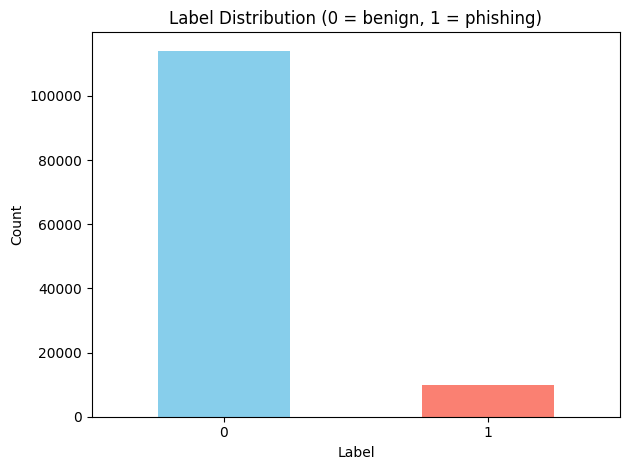

In [63]:


label_counts = all_emails_df['label'].value_counts()
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Label Distribution (0 = benign, 1 = phishing)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
